In [1]:
from google.colab import drive
drive.mount('/content/drive')

# change this to the path in google drive where the files are located
%cd /content/drive/MyDrive/TDDE16-Project

Mounted at /content/drive
/content/drive/MyDrive/TDDE16-Project


In [25]:
#!pip install transformers
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler

In [3]:
pd.set_option('display.max_colwidth', 200)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [34]:
DATA_PATH = 'IMDB Dataset.csv'
BERT_MODEL = 'bert-base-uncased'
ROBERTA_MODEL = 'roberta-large'
SAVED_BERT_MODEL = '/content/drive/MyDrive/TDDE16-Project/BERT model/pytorch_model.bin'
SAVED_ROBERTA_MODEL = '/content/drive/MyDrive/TDDE16-Project/Roberta model/pytorch_model.bin'

# Configuration for the BERT and RoBERTa model
MAX_LEN = 512
BATCH_SIZE = 8
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS= 5

In [5]:
# Cleaning the data
df = (pd.read_csv(DATA_PATH).drop_duplicates())
print(f'Numbers of samples: {len(df)}')
df.head()

Numbers of samples: 49582


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


In [6]:
# Converting the target valur to integers
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == "negative" else 1)
print(df['sentiment'].value_counts())

1    24884
0    24698
Name: sentiment, dtype: int64


#Identifyting the top 10 terms with lowest idf value for both positive and nevative reviews.

In [7]:
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'textcat'])

def preprocess(text):
    return [token.lemma_ for token in nlp(text) if not token.is_stop and token.is_alpha]

In [8]:
#Seperating the positive and negative reviews
positive_reviews = df[df['sentiment']==1]
negative_reviews = df[df['sentiment']==0]

print(f'positive_reviews count: {positive_reviews.count()}, negative_reviews count: {negative_reviews.count()}')

positive_reviews count: review       24884
sentiment    24884
dtype: int64, negative_reviews count: review       24698
sentiment    24698
dtype: int64


#Finding the top 10 terms in positive sentiment movie reviews

In [9]:
X = np.zeros((len(positive_reviews), 1))
vectorizer = TfidfVectorizer(tokenizer = preprocess)
X = vectorizer.fit_transform(positive_reviews['review'])

postive_vocab = pd.DataFrame((zip(vectorizer.get_feature_names_out(), vectorizer.idf_)), columns = ['term', 'idf'])
postive_vocab.sort_values(by = ['idf', 'term'], inplace=True, ascending=True)

print(postive_vocab[:10])
print(postive_vocab[-10:])

            term       idf
18955       film  1.515256
35805      movie  1.521464
21965       good  1.676134
31168       like  1.787076
53912       time  1.913983
22377      great  2.019822
47344        see  2.027091
51163      story  2.075847
58526      watch  2.103204
8775   character  2.115021
             term        idf
60672           ð  10.428873
60675       örnek  10.428873
60676     özdemir  10.428873
60677      østbye  10.428873
60679  übermensch  10.428873
60680        ünel  10.428873
60681  ünfaithful  10.428873
60682           ý  10.428873
60683          ýs  10.428873
60684         þór  10.428873


#Finding the top 10 terms in negative sentiment movie reviews

In [10]:
Y = np.zeros((len(positive_reviews), 1))
vectorizer = TfidfVectorizer(tokenizer = preprocess)
Y = vectorizer.fit_transform(negative_reviews['review'])

negative_vocab = pd.DataFrame((zip(vectorizer.get_feature_names_out(), vectorizer.idf_)), columns = ['term', 'idf'])
negative_vocab.sort_values(by = ['idf', 'term'], inplace=True, ascending=True)

print(negative_vocab[:10])
print(negative_vocab[-10:])

            term       idf
33906      movie  1.363075
18124       film  1.543989
29475       like  1.646208
3476         bad  1.767813
20928       good  1.804423
51306       time  1.930830
55725      watch  1.956524
44950        see  2.092799
51025      think  2.105927
8267   character  2.123827
                 term        idf
57867          önsjön  10.421371
57868               ø  10.421371
57869            úber  10.421371
57871  übermenschlich  10.421371
57872       überwoman  10.421371
57873      üvegtigris  10.421371
57874          üzümcü  10.421371
57875     þorleifsson  10.421371
57876            יגאל  10.421371
57877           כרמון  10.421371


#Summary:

After looking at the top 10 terms from both postive and negative movie reviews, it can be noticeed that there are some words specific to the movies, such as, 'movie', 'film', 'character', 'scene', 'story', etc. These words can be treated as stop words. 

The model can perform a little bit better if stop words related to movie industry can be identfied and removed before training the model.

# Compariing the performance of BERT and RoBERa

In [11]:
# Test function
def test(model, dataloader, device):
    y_preds = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
         
            y_preds.extend( torch.argmax(outputs.logits, dim=1) )
            y_true.extend( batch['labels'])
            
        return y_preds, y_true

In [12]:
# Function to Removes html tags and  extra whitespaces.
def clean_text(text):
    text =  " ".join(text.split())
    text = re.sub(r'<.*?>', '', text)
    return text

In [13]:
# Class for creating dataset
# To be passed as an argument to the Dataloader
class CreateDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text=None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        y = torch.tensor(self.target[idx], dtype=torch.long)
        X = str(self.review[idx])
        if self.clean_text:
            X = self.clean_text(X)
        
        encoded_X = self.tokenizer(
            X, 
            return_tensors = 'pt', 
            max_length = self.max_len, 
            truncation=True,
            padding = 'max_length'
            )

        return {'input_ids': encoded_X['input_ids'].squeeze(),
                'attention_mask': encoded_X['attention_mask'].squeeze(),
                'labels': y}

In [14]:
#Function to return the False Positives and False Negatives
def error_report(df, gold, pred):
    fp = []
    fn = []
    for g, p, sen in zip(gold, pred, df['review']):
      if g==1 and p==0:
        fp.append(sen)
      elif g==0 and p==1:
        fn.append(sen)
    return fp, fn

#Loading the BERT Model

In [17]:
# Creating train, validation and test datasets
train_df, test_val_df = train_test_split(df, test_size=0.3, stratify=df['sentiment'], random_state=20)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['sentiment'], random_state=20)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Length of train set: {len(train_df)}')
print(f'Length of validation set: {len(val_df)}')
print(f'Length of test set: {len(test_df)}')

Length of train set: 34707
Length of validation set: 7437
Length of test set: 7438


In [ ]:
# Setting up the model, the optimizer and the scheduler
# Using BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=NUM_CLASSES)
model.to(device)

In [18]:
# Tokenizing the data using BertTokenizer
# Using Dataloader
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
bert_dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    bert_dataloaders[df] = DataLoader(CreateDataset(dfs[df]['review'],  dfs[df]['sentiment'], tokenizer=bert_tokenizer, max_len=MAX_LEN, clean_text=clean_text),
                                  batch_size=BATCH_SIZE, shuffle=should_shuffle)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [19]:
# model = torch.load(output_dir, map_location=torch.device('cpu'))
model.load_state_dict(torch.load(SAVED_BERT_MODEL), strict=False)

<All keys matched successfully>

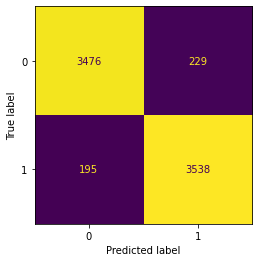

In [20]:
y_preds, y_true = test(model,bert_dataloaders['test'], device)

#Confusion Matrix
_ , ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = False);

In [21]:
#Classification report
print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3705
           1       0.94      0.95      0.94      3733

    accuracy                           0.94      7438
   macro avg       0.94      0.94      0.94      7438
weighted avg       0.94      0.94      0.94      7438



In [23]:
#Analysing the false positives and false negatives
fp, fn = error_report(test_df, y_true, y_preds)
fp

['I would like if they brought back surface. I really enjoyed the show along with my family. I felt the plot development and storyline were first rate. Like the other person said, it seems that everything gets reduced to the lowest common denominator. Nothing but bland, politically correct junk survives. Just look at the internet to see how many people were watching the show. Also it is not nice to leave us hanging as to what happened the all of the characters on the show. This is the same thing that happened to the time travel show I think was called 8 days but should have been called backstep. Did the Olympics kill surface? I know the writers strike killed another one of my favorite shows years ago called greatest American hero.',
 '. . . is just as good as the original. Very nearly achieves greatness because of Cundieff\'s remarkable ear for music and dialogue. Skewers the self-important swagger of the hip-hop poseurs. The group "Niggaz with Hats" (NWH) are every rap group you ever 

In [24]:
fn

['The "saucy" misadventures of four au pairs who arrive in London on the same day in the early 1970s. There\'s a Swedish girl, a Danish, a German and a Chinese. The story contrives to get the clothes off all of them, involve them in some Carry On-type humour and couple them with various misfits from the British film and TV culture of the time, including Man About the House star Richard O\'Sullivan, future Coronation Street rogue Johnny Briggs and horror film stalwart Ferdy Mayne (playing a sheik). There\'s a pretty risqué amount of female nudity on display, for those who like that kind of thing (but obviously nothing hardcore).<br /><br />Most of the film is pretty thin and inconsequential; the girls are stereotypes, and German Anita especially suffers from some kind of infantalising disorder - she\'s a moron obsessed with colour TV who acts like a kind of uninhibited child & dresses to deliberately show her private parts; in another more serious film, she would be a psychiatric case. 

#Loading the RoBERTa Model

In [ ]:
# Setting up the model, the optimizer and the scheduler
# Using RobertaForSequenceClassification model
roberta_model = RobertaForSequenceClassification.from_pretrained(ROBERTA_MODEL, num_labels=NUM_CLASSES)
roberta_model.to(device)

In [36]:
# Tokenizing the data using RobertaTokenizer
# Using Dataloader
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
roberta_dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    roberta_dataloaders[df] = DataLoader(CreateDataset(dfs[df]['review'],  dfs[df]['sentiment'], tokenizer=roberta_tokenizer, max_len=MAX_LEN, clean_text=clean_text),
                                  batch_size=BATCH_SIZE, shuffle=should_shuffle)

In [37]:
# model = torch.load(output_dir, map_location=torch.device('cpu'))
roberta_model.load_state_dict(torch.load(SAVED_ROBERTA_MODEL), strict=False)

<All keys matched successfully>

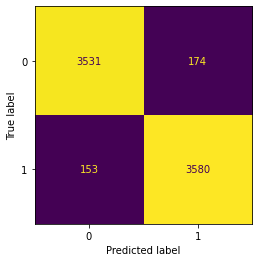

In [41]:
roberta_y_preds, roberta_y_true = test(roberta_model,roberta_dataloaders['test'], device)

#Confusion Matrix
_ , ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(torch.tensor(roberta_y_true), torch.tensor(roberta_y_preds), ax = ax, colorbar = False);

In [42]:
#Classification report
print(classification_report(torch.tensor(roberta_y_true), torch.tensor(roberta_y_preds)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3705
           1       0.95      0.96      0.96      3733

    accuracy                           0.96      7438
   macro avg       0.96      0.96      0.96      7438
weighted avg       0.96      0.96      0.96      7438



In [43]:
#Analysing the false positives and false negatives
r_fp, r_fn = error_report(test_df, roberta_y_true, roberta_y_preds)
r_fp

['I would like if they brought back surface. I really enjoyed the show along with my family. I felt the plot development and storyline were first rate. Like the other person said, it seems that everything gets reduced to the lowest common denominator. Nothing but bland, politically correct junk survives. Just look at the internet to see how many people were watching the show. Also it is not nice to leave us hanging as to what happened the all of the characters on the show. This is the same thing that happened to the time travel show I think was called 8 days but should have been called backstep. Did the Olympics kill surface? I know the writers strike killed another one of my favorite shows years ago called greatest American hero.',
 "This program was on for a brief period when I was a kid, I remember watching it whilst eating fish and chips.<br /><br />Riding on the back of the Tron hype this series was much in the style of streethawk, manimal and the like, except more computery. Ther

In [44]:
r_fn

['This is a pretty simplistic romance. Girl finds boy, girl loves boy, girl loses boy, girl finds boy. Colleen Moore is the outstanding ingredient in this recipe, delivering a wonderfully varied dramatic/romantic performance, well deserving of an Oscar nom. Equally fine are the aerial combat special effects.<br /><br />Moore plays a French girl whose mother has turned over their field to a British aerial squadron during WWI. She is the "daughter of the regiment", loved as a little sister. Into this mix comes a fill-in for a downed flyer, Gary Cooper. At first they hate each other, then they love each other, then the entire squadron is sent out on a suicide mission. Cooper returns but crashes in the village and a red cross unit removes him. Moore searches for him, is told at a hospital he is dead, then wanders the streets until he calls from a hospital window and they are reunited.<br /><br />It\'s a nice little romance, but hardly more than that. Recommended for fans of Ms. Moore and M

#Summary:
After looking at the miss-classified reviews, the following conclusions can be drawn:

* Most miss-classified reviews have length much greater than 512 words, which is the maximum padding length of each review. Which makes it harder to classify.

* After reading some of the miss-classified reviews, it can be observed that most reviews does not talk about the movie or the experience of the person who is watching the movie, but is the summary of their whole day

* Roberta model seems to perform better than the bert model.